In [ ]:
!mamba install pytorch=1.12 torchvision torchaudio cudatoolkit=11.3 -c pytorch -y -q

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-geometric

In [ ]:
!mamba install -c conda-forge pyts -q -y

In [ ]:
!pip install llvmpy
!pip install cython
!pip install numba
!pip install pandas
!pip install networkx
!pip install matplotlib
!pip install ts2vg

In [22]:
import pandas as pd
import numpy as np
import torch
import warnings
import torch.nn.functional as F
import sklearn
import os.path as osp
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from pyts.image import MarkovTransitionField
from sklearn.utils import class_weight

from torch.nn import Linear, CrossEntropyLoss
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, ChebConv, global_sort_pool
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GINEConv, GATv2Conv, GATConv

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE

import ts2vg
from ts2vg import NaturalVG
from ts2vg import HorizontalVG

In [7]:
#function for graph creation
def create_MTF_graph():
    warnings.filterwarnings("ignore")
    # preparation for un/cut graphs
    if len_type == "un/cut":
    
        df = pd.read_csv(path_main)  
        del df['Unnamed: 0']
        df.index, df.columns = [range(df.index.size), range(df.columns.size)]
        length_rss = int((df.columns.stop-2)/2)
        
        X = df.loc[:,df.columns[:length_rss]].to_numpy()
        Y = df[length_rss+1].to_numpy(dtype=np.uint8)
        X_mask = df.loc[:,df.columns[length_rss+2:]].to_numpy()
        
        MTF = MarkovTransitionField(n_bins=length_rss)
        X_gaf = MTF.fit_transform(X)
        
    # preparation for random graphs
    elif len_type == "random":
        dataset_rss = np.load(path_main, allow_pickle=True)['arr_0']
        dataset_properties = np.load(path_properties, allow_pickle=True)['arr_0']
        dataset_mask = np.load(path_mask, allow_pickle=True)['arr_0']

        for i in range(len(dataset_properties)):
            if  dataset_properties[i,1] == True:
                dataset_properties[i,1] = 1
            else:
                dataset_properties[i,1] = 0
        
        X = dataset_rss
        X_mask = dataset_mask
        Y = dataset_properties[:,2]
        Y_len = dataset_properties[:,0]

        X_gaf = []
        for i in range(len(Y_len)):
            
            MTF = MarkovTransitionField(n_bins=Y_len[i])
            X_gaf_temp = MTF.fit_transform(X[i].reshape(1, -1))
            X_gaf.append(X_gaf_temp[0])
    
    # output will have all graphs 
    output = []
    
    # setting class_weights for graph
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
    # function for creating edge index and edge weight for a given MTF matrix
    def adjToEdgidx(adj_mat):
        edge_index = torch.from_numpy(adj_mat).nonzero().t().contiguous()
        row, col = edge_index
        edge_weight = adj_mat[row, col]#adj_mat[row, col]
        return edge_index, edge_weight
    
    for i, j in enumerate(X_gaf):
        edge_index, edge_weight = adjToEdgidx(j)
        #Into Data save node values "x", edge index from adjacency matrix and edge features/attributes, finally labels
        
        if classif == "graph": # for graph classification
            y_mask = torch.tensor(Y[i], dtype=torch.long)      
        elif classif == "node":                 # for node classification 
            y_mask = torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)
            
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), edge_index=edge_index, edge_attr=torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1), y=y_mask))
    
    return output

In [8]:
 #function for graph creation
def create_visual_graph():
    # warnings.filterwarnings("ignore")
    # preparation for un/cut graphs
    if len_type == "un/cut":
    
        df = pd.read_csv(path_main)  
        del df['Unnamed: 0']
        df.index, df.columns = [range(df.index.size), range(df.columns.size)]
        length_rss = int((df.columns.stop-2)/2)
        
        X = df.loc[:,df.columns[:length_rss]].to_numpy()
        Y = df[length_rss+1].to_numpy(dtype=np.uint8)
        X_mask = df.loc[:,df.columns[length_rss+2:]].to_numpy()
        
        
    # preparation for random graphs
    elif len_type == "random":
        
        dataset_rss = np.load(path_main, allow_pickle=True)['arr_0']
        dataset_properties = np.load(path_properties, allow_pickle=True)['arr_0']
        dataset_mask = np.load(path_mask, allow_pickle=True)['arr_0']

        for i in range(len(dataset_properties)):
            if  dataset_properties[i,1] == True:
                dataset_properties[i,1] = 1
            else:
                dataset_properties[i,1] = 0
        
        X = dataset_rss
        X_mask = dataset_mask
        Y = dataset_properties[:,2]
        Y_len = dataset_properties[:,0]

    # output will have all graphs 
    output = []
    
    # setting class_weights for graph
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
    # function for creating edge index and edge weight for a given MTF matrix
    def adjToEdgidx(X_current):
        g = NaturalVG(weighted='distance')
        # g = HorizontalVG(weighted='distance')
        g.build(X_current)

        adj_mat_visual = np.zeros([len(X_current),len(X_current)], dtype='float')
        for i in range(len(g.edges)):
            x, y, q =g.edges[i]
            adj_mat_visual[x,y] = q#/g.weights.max()
            adj_mat_visual[y,x] = q#/g.weights.max()
        
        edge_index = torch.from_numpy(adj_mat_visual).nonzero().t().contiguous()
        row, col = edge_index
        edge_weight = adj_mat_visual[row, col]
        
        return edge_index, edge_weight
    
    for i in range(len(X)):
        edge_index, edge_weight = adjToEdgidx(X[i])
        
        if classif == "graph": # for graph classification
            y_mask = torch.tensor(Y[i], dtype=torch.long)      
        elif classif == "node":                 # for node classification 
            y_mask = torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)
        
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                           edge_index=torch.tensor(edge_index, dtype=torch.int64), 
                           edge_attr=torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1),
                           y=y_mask))
    return output


In [ ]:
def create_join_graph():
    
    warnings.filterwarnings("ignore")
    # preparation for un/cut graphs
    if len_type == "un/cut":
    
        df = pd.read_csv(path_main)  
        del df['Unnamed: 0']
        df.index, df.columns = [range(df.index.size), range(df.columns.size)]
        length_rss = int((df.columns.stop-2)/2)
        
        X = df.loc[:,df.columns[:length_rss]].to_numpy()
        Y = df[length_rss+1].to_numpy(dtype=np.uint8)
        X_mask = df.loc[:,df.columns[length_rss+2:]].to_numpy()
        
        MTF = MarkovTransitionField(n_bins=length_rss)
        X_gaf = MTF.fit_transform(X)
        
    # preparation for random graphs
    elif len_type == "random":
        dataset_rss = np.load(path_main, allow_pickle=True)['arr_0']
        dataset_properties = np.load(path_properties, allow_pickle=True)['arr_0']
        dataset_mask = np.load(path_mask, allow_pickle=True)['arr_0']

        for i in range(len(dataset_properties)):
            if  dataset_properties[i,1] == True:
                dataset_properties[i,1] = 1
            else:
                dataset_properties[i,1] = 0
        
        X = dataset_rss
        X_mask = dataset_mask
        Y = dataset_properties[:,2]
        Y_len = dataset_properties[:,0]

        X_gaf = []
        for i in range(len(Y_len)):
            
            MTF = MarkovTransitionField(n_bins=Y_len[i])
            X_gaf_temp = MTF.fit_transform(X[i].reshape(1, -1))
            X_gaf.append(X_gaf_temp[0])
    
    # output will have all graphs 
    output = []
    
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
        
    def adjToEdgidx(adj_mat_MTF,X_current):
        g = NaturalVG(weighted='distance')
        #g = HorizontalVG(weighted='distance')
        g.build(X_current)
        
        #create matrix for visual
        adj_mat_visual = np.zeros([len(adj_mat_MTF),len(adj_mat_MTF)], dtype='float')
        for i in range(len(g.edges)):
            x, y, q =g.edges[i]
            adj_mat_visual[x,y] = q#/g.weights.max()
            adj_mat_visual[y,x] = q#/g.weights.max()
        
        edge_index = torch.from_numpy(adj_mat_MTF).nonzero().t().contiguous()
        
        #join two edge_weight arrays (visual is converted to fit MTF) 
        row, col = edge_index
        edge_weight = np.zeros([len(row),2], dtype='float')
        edge_weight[:,0] = adj_mat_MTF[row, col]
        edge_weight[:,1] = adj_mat_visual[row, col]
        
        # edge_weight = np.reshape(edge_weight,(len(edge_weight),2))
        
        return edge_index, edge_weight
    
    for i, j in enumerate(X_gaf):
        edge_index, edge_weight = adjToEdgidx(j,X[i])
        
        if classif == "graph": # for graph classification
            y_mask = torch.tensor(Y[i], dtype=torch.long)      
        elif classif == "node":                 # for node classification 
            y_mask = torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)
            
        #Into Data save node values "x", edge index from adjacency matrix and edge features/attributes, finally labels       
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                    edge_index=edge_index, 
                    edge_attr=torch.tensor(edge_weight, dtype=torch.double), 
                    y=y_mask))
    return output

In [9]:
## Focal loss definition

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma=1, alpha=None, ignore_index=-100, reduction='mean'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        
        
        if self.reduction == 'mean':
            return torch.mean(loss) 
        elif self.reduction == 'sum':
            return torch.sum(loss) 
        else:
            return loss

In [11]:
## Graph Clasification

In [12]:
# model definition for graph classification
class GINE(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GINE, self).__init__()
        edge_dim = 1
        
        self.conv1 = GINEConv(
            Sequential(Linear(dim_h, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv2 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv3 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv4 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv5 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.lin1 = Linear(dim_h*5, dim_h*5)
        self.lin2 = Linear(dim_h*5, 5)

    def forward(self, data):
        
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Node embeddings 
        h1 = self.conv1(x, edge_index, edge_attr=edge_weight)
        h2 = self.conv2(h1, edge_index, edge_attr=edge_weight)
        h3 = self.conv3(h2, edge_index, edge_attr=edge_weight)
        h4 = self.conv4(h3, edge_index, edge_attr=edge_weight)
        h5 = self.conv5(h4, edge_index, edge_attr=edge_weight)
        
        # Graph-level readout
        
        h1 = global_max_pool(h1, batch)
        h2 = global_max_pool(h2, batch)
        h3 = global_max_pool(h3, batch)
        h4 = global_max_pool(h4, batch)
        h5 = global_max_pool(h5, batch)
        

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3, h4, h5), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h

In [44]:
# # # function for training the model
# # def trainG(model, loader, epoch, optimizer, device):
# #     model.train()
# #     total_loss = 0

# #     with tqdm(loader, unit="batch") as tepoch:
# #          for data in tepoch:
# #             tepoch.set_description(f"Epoch {epoch}")
# #             optimizer.zero_grad()
# #             data = data.to(device)
# #             out = model(data)
            
# #             # define loss_function
# #             loss_function = CrossEntropyLoss(weight=class_weights.to(device))
# #             loss = loss_function(out, data.y)
# #             loss.backward()
# #             optimizer.step()
# #             total_loss += loss.item() * data.num_graphs
# #     return total_loss / len(loader.dataset)

# # # function for testing the model
# # def testG(model, loader, device):
# #     model.eval()

# #     correct = 0
# #     predicted_categories = []
# #     true_categories = []
# #     with tqdm(loader, unit="batch") as tepoch:
# #         for data in tepoch:
# #         # Iterate in batches over the training/test dataset.
# #             data = data.to(device)
# #             out = model(data)  
            
# #             # Use the class with highest probability.
# #             pred = out.argmax(dim=1)
# #             predicted_categories.append(pred.cpu().detach().numpy())
# #             true_categories.append(data.y.cpu().detach().numpy())
            
# #             # Check against ground-truth labels.
# #             correct += int((pred == data.y).sum())
# #     print(confusion_matrix(true_categories, predicted_categories))
# #     print(classification_report(true_categories, predicted_categories))  
    
# #     # Derive ratio of correct predictions.
# #     return correct / len(loader.dataset)  

# def trainG(model, loader, epoch, optimizer, device):
#     model.train()
#     total_loss = 0

#     with tqdm(loader, unit="batch") as tepoch:
#          for data in tepoch:
#             tepoch.set_description(f"Epoch {epoch}")
#             optimizer.zero_grad()
#             data = data.to(device)
#             out = model(data)
#             loss_function = CrossEntropyLoss(weight=class_weights.to(device))
#             #loss_function = FocalLoss()
#             loss = loss_function(out, data.y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item() * data.num_graphs
#     return total_loss / len(loader.dataset)

# def testG(model, loader, device):
#     model.eval()

#     correct = 0
#     predicted_categories = []
#     true_categories = []
#     with tqdm(loader, unit="batch") as tepoch:
#         for data in tepoch:
#       # Iterate in batches over the training/test dataset.
#             data = data.to(device)
#             out = model(data)  
#             pred = out.argmax(dim=1)# Use the class with highest probability.
#             predicted_categories.append(pred.cpu().detach().numpy())
#             true_categories.append(data.y.cpu().detach().numpy())
#             correct += int((pred == data.y).sum())# Check against ground-truth labels.
#     #print(confusion_matrix(true_categories, predicted_categories))
#     #print(classification_report(true_categories, predicted_categories))  
#     return (correct / len(loader.dataset)), true_categories, predicted_categories   # Derive ratio of correct predictions.

In [61]:
def trainG(model, loader, epoch, optimizer, device):
    model.train()
    total_loss = 0


    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss_function = CrossEntropyLoss(weight=class_weights.to(device))
        #loss_function = FocalLoss()
        loss = loss_function(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def testG(model, loader, device):
    model.eval()

    correct = 0
    predicted_categories = []
    true_categories = []
    with tqdm(loader, unit="batch") as tepoch:
        for data in tepoch:
      # Iterate in batches over the training/test dataset.
            data = data.to(device)
            out = model(data)  
            pred = out.argmax(dim=1)# Use the class with highest probability.
            predicted_categories.append(pred.cpu().detach().numpy())
            true_categories.append(data.y.cpu().detach().numpy())
            correct += int((pred == data.y).sum())# Check against ground-truth labels.
    #print(confusion_matrix(true_categories, predicted_categories))
    #print(classification_report(true_categories, predicted_categories))  
    return (correct / len(loader.dataset)), true_categories, predicted_categories   # Derive ratio of correct predictions.

In [53]:
def graph_classification():
    
    # calling the graph creator function
    output = generate_output()
    torch.manual_seed(6406)
    
    # setting train and test sizes
    train_size = int(0.8 * len(output))
    test_size = len(output) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(output, [train_size, test_size])
    loader_train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    loader_test = DataLoader(test_dataset, batch_size = 1)
    
    # setting device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    
    # creating model
    model = GINE(32).double().to(device)
    
    # selecting the optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

    #variables and arrays for results
    loss_plot = np.empty([range_epoch], dtype='float64')
    acc_plot = np.zeros([range_epoch], dtype='float64')
    best_score = 0
    # run for number of epochs
    for epoch in range(range_epoch):
        
        result = trainG(model, loader_train, epoch, optimizer, device)
        loss_plot[epoch] = result
        
        if epoch >= epoch_min:
            if epoch%epoch_interval == 0 or epoch == range_epoch:
                score, true_categories, predicted_categories = testG(model, loader_test, device)
                
                acc_plot[epoch] = score
                if best_score < score:
                    best_score = score
                    best_tcs = true_categories
                    best_pc = predicted_categories
                    best_e = epoch
                
                    
    print('Done!')
    
    print(confusion_matrix(best_tcs, best_pc))
    print(classification_report(best_tcs, best_pc)) 
    print(best_e)
    if analysis == True:
        return loss_plot, acc_plot
    else:
        return best_tcs, best_pc

In [15]:
## Node Clasification

In [16]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = GATConv(1, 4, heads=4)
        self.lin1 = torch.nn.Linear(1, 16)
        self.conv2 = GATConv(16, 4, heads=4)
        self.lin2 = torch.nn.Linear(16, 16)
        self.conv3 = GATConv(16, 1, heads=6,concat=False)
        self.lin3 = torch.nn.Linear(16, 1)
          
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

In [17]:
# function for training and validating the model
def trainN(model, epoch, optimizer, device):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x.float(), data.edge_index), data.y)
        total_loss += loss.item() * len(train_loader)
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
# function for testing the model
def testN(model, loader, device):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.float().to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())  
        
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0, ys,preds

In [37]:
def node_classification():
    
    # calling the graph creator function
    
    output = generate_output()
        
    torch.manual_seed(6406)
    
    # setting train, val and test sizes
    train_size = int(0.6 * len(output))
    Temp_size = len(output) - train_size
    val_size = int(0.5*Temp_size)
    test_size = Temp_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(output, [train_size, val_size, test_size])

    global train_loader, val_loader, test_loader, loss_op
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    
    #setting device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()

    #creating model
    model = Net().to(device)
    # define loss
    loss_op = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

    # run for number of epochs
    for epoch in range(range_epoch):
        loss = trainN(model, epoch, optimizer, device)
        val_f1,ys,preds = testN(model, val_loader, device)
        test_f1,ys,preds = testN(model, test_loader, device)

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, 'f'Test: {test_f1:.4f}')
        
    print(sklearn.metrics.multilabel_confusion_matrix(ys[0], preds[0]))
    print(sklearn.metrics.classification_report(ys[0], preds[0]))

In [19]:
#keeps the last output so we dont have to generate another if all parameters are the same as beffore
global temp_repeat
temp_repeat=['']*6
def generate_output():
    if temp_repeat[0] != graph_type or temp_repeat[1] != classif or temp_repeat[2] != len_type or temp_repeat[3] != path_main or temp_repeat[4] != path_properties or temp_repeat[5] != path_mask:
    
        global output
        if graph_type == "MTF":
            output = create_MTF_graph()
        if graph_type == "visual":
            output = create_visual_graph()
    
    temp_repeat[0] = graph_type 
    temp_repeat[1] = classif
    temp_repeat[2] = len_type
    temp_repeat[3] = path_main
    temp_repeat[4] = path_properties
    temp_repeat[5] = path_mask
    
    return output

In [56]:
def run_pypeline():
    if analysis ==True:   
        if classif == "graph":
            loss_plot, acc_plot = graph_classification()

        if classif == "node":
            loss_plot, acc_plot = node_classification()
        return loss_plot, acc_plot 
    else:
        if classif == "graph":
            best_tcs, best_pc, best_score = graph_classification()

        if classif == "node":
            best_tcs, best_pc = node_classification()
        return best_tcs, best_pc

In [ ]:
# try: 
#     result_save = pd.read_csv("result_save.csv")
# else:
#     result_save = pd.to_csv("result_save.csv")

In [60]:
graph_type = "visual"#"visual", "MTF"
classif = "graph" #"graph", "node", set the type of classification
len_type = "un/cut" #"un/cut", "random", set the shape of data used in later paths 
path_main = "dataset_uncut.csv" # "dataset_cut.csv", "dataset_rss.npz", paths used for cut/uncut/random dataset
path_properties = "dataset_properties.npz"  # path to properties used for random 
path_mask = "dataset_mask.npz" # path to mask dataset used for random

batch_size = 64*2 #set the train batch size
learning_rate = 0.01
range_epoch = 1000 #set length of epoch
epoch_min = 5
epoch_interval = 5

analysis = True

#run the function to get results for all the properties stated above
loss_plot3, acc_plot3 = run_pypeline()

Epoch 999: 100%|██████████| 67/67 [00:01<00:00, 51.29batch/s]


Done!
[[424   0   0  10   6]
 [  1 414  19   0   1]
 [  0   2 399   5   0]
 [  6   0   0 413   1]
 [  7   0   1   1 413]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       440
           1       1.00      0.95      0.97       435
           2       0.95      0.98      0.97       406
           3       0.96      0.98      0.97       420
           4       0.98      0.98      0.98       422

    accuracy                           0.97      2123
   macro avg       0.97      0.97      0.97      2123
weighted avg       0.97      0.97      0.97      2123

435


In [62]:
path_main = "dataset_250_cut.csv"
loss_plot2, acc_plot2 = run_pypeline()

 60%|█████▉    | 1271/2123 [00:03<00:02, 334.31batch/s]


KeyboardInterrupt: 

In [ ]:
path_main = "dataset_200_cut.csv"
loss_plot2, acc_plot2 = run_pypeline()

In [ ]:
path_main = "dataset_150_cut.csv"
loss_plot2, acc_plot2 = run_pypeline()

In [ ]:
path_main = "dataset_100_cut.csv"
loss_plot2, acc_plot2 = run_pypeline()

In [ ]:
path_main = "dataset_50_cut.csv"
loss_plot2, acc_plot2 = run_pypeline()

In [ ]:
path_main = "dataset_uncut.csv" 

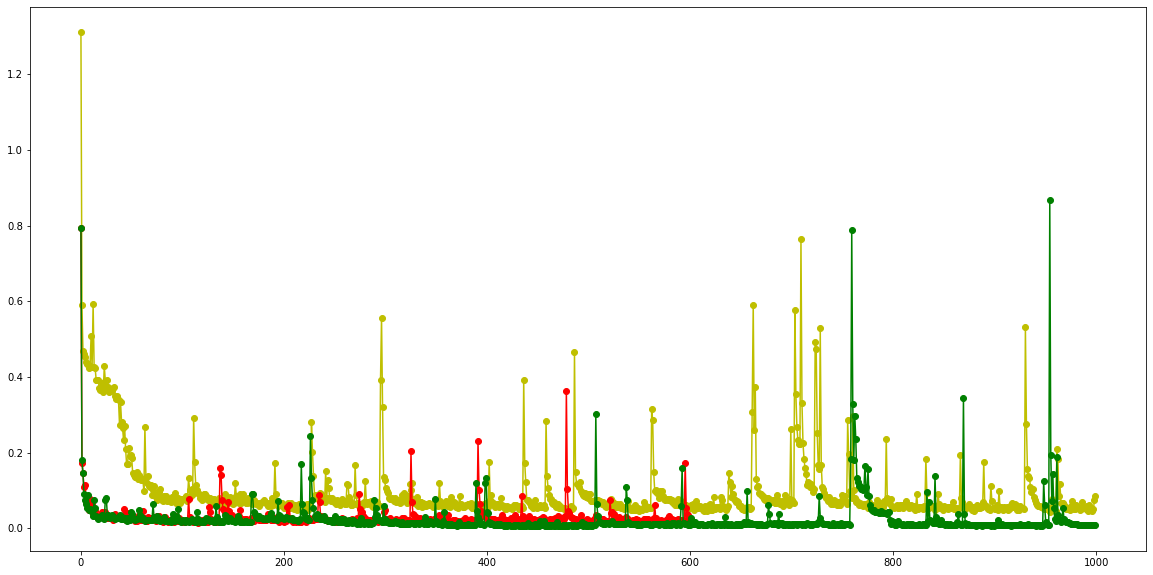

In [64]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(loss_plot, '-yo')# main visual
plt.plot(loss_plot2, '-ro')# main visual
plt.plot(loss_plot3, '-go')# main visual


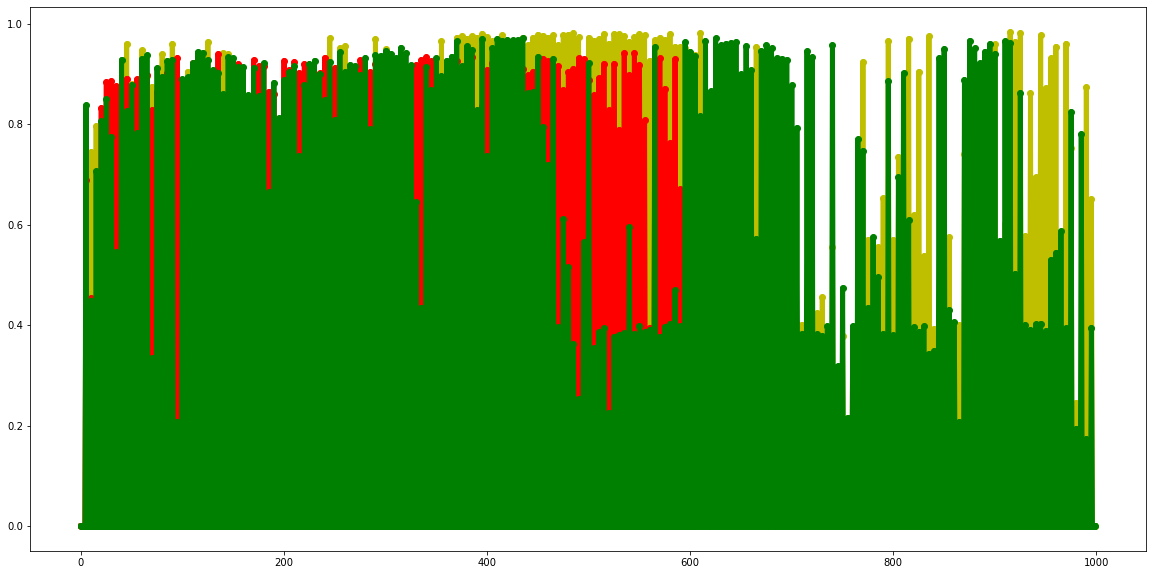

In [65]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(acc_plot, '-yo',linewidth=5)
plt.plot(acc_plot2, '-ro',linewidth=5)
plt.plot(acc_plot3, '-go',linewidth=5)